# Generate ensemble parameter combinations

This is specifically for the cultivar file

In [ ]:
# this loads previoulsy stored environment
import dill
dill.load_session('opt_param_env.db')

In [37]:
import os
import pandas as pd
import numpy as np
import glob as glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from pyDOE import *

# personal functions
from funcs import unfold, tup_convert

### Step 1. Create dataframe with all parameters
* phenology
    - staygreen *
    - juv_leaves *
    - maxElongRate: max elongation rate at optimal temperature (12 cm/day)
    - rmax_lir: max leaf initation rate (leaves/day) *
    - rmax_ltar: max leaf tip appearance rate (leaves/day) *
* morphology
    - LAF: leaf angle factor for corn leaves (1.37)
    - f: spectral correction (0.15) *
    - scatt: leaf reflectance and transmittance (0.15) *
    - leaf_wid: leaf width (0.05 m) *
    - WLRARIO: leaf width to length ratio (0.106)
    - A_LW: leaf area coefficient with respect to LxW (0.75)
* physiology
    - vcm25: *
    - vpm25: *
    - g0: *
    - g1: *
    - t_opt: 
* water stress
    - psi_threshold: 

In [38]:
# genetic parameter list
params = ['g0', 'g1', 'shootPart', 'rootPart', 'Vpmax', 'T_opt', 'psi_threshold', # physiology          
          'stayGreen', 'max_ElongRate', 'rmax_ltar', 'juv_leaves', # phenology
          'LAF', 'leaf_width', 'A_LW', 'LM_min'] # morphology

#### ensemble paramter range

In [4]:
# JH 200506: range of these parameters still need to be checked/updated
#            value range need to be literatuer-based (need to cite)
param_range = {'staygreen':[1,6],
               'rmax_lir': [0.1, 0.5],
               'rmax_ltar': [0.1, 1.5],
               'juv_leaves': [12, 20],
               'leaf_wid': [0.02, 0.08],
               'WLRATIO': [1, 2],
               'A_LW': [0.5, 1],
               'LAF': [1, 3],
               'f': [0, 1],
               'scatt': [0, 1],
               'vcm_25': [40, 60],
               'vpm_25': [60, 80],
               'g0': [0.02, 0.16], # loosely based these ranges on 
               'g1': [1, 10],      # Miner et al., 2017
               't_opt': [20, 28],
               'psi_threshold': [-5, -1]}

### Step 2. Latin hypercube parameter sampling
Info on this method here: https://pythonhosted.org/pyDOE/randomized.html <br/>
Only execute this code block once, if executed once more, everything will be randomized again

In [35]:
#sample = lhs(len(params), samples=100)
#df_params = pd.DataFrame(sample, columns=params)

#df_parameters = pd.DataFrame()
#for i in params: 
#    df_parameters[i] = unfold(df_params[i], param_range[i][0], param_range[i][1])
#df_parameters.juv_leaves = [round(x) for x in df_parameters.juv_leaves]
#df_parameters.to_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv', index=False)

In [49]:
df_parameters.head()

,staygreen,rmax_lir,rmax_ltar,juv_leaves,leaf_wid,WLRATIO,A_LW,LAF,f,scatt,vcm_25,vpm_25,g0,g1,t_opt,psi_threshold
0,4.192327,0.170936,1.116221,19,0.060117,1.578166,0.578437,1.082704,0.374039,0.799075,41.453395,63.020343,0.050014,4.262101,23.156285,-3.209627
1,5.085099,0.458642,0.532489,13,0.053712,1.593230,0.944650,2.500608,0.084047,0.638286,55.254491,76.360963,0.045041,9.476365,21.452484,-4.528151
2,5.462802,0.409265,1.126607,19,0.055231,1.452949,0.615309,1.305084,0.209307,0.547004,40.314858,68.638982,0.071773,3.290494,25.081642,-1.387541
3,2.468920,0.159873,0.209975,14,0.021548,1.951003,0.603160,1.430029,0.198690,0.216546,53.057031,71.797256,0.102321,3.169339,26.865773,-3.101738
4,2.217561,0.478633,0.463970,16,0.045654,1.027741,0.790700,1.147568,0.793187,0.582211,50.710891,78.179130,0.099021,6.539257,27.086055,-1.328671


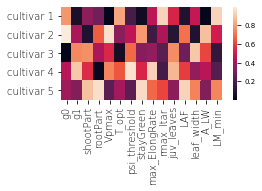

In [50]:
# visualizing parameter spread:
sample = lhs(len(params), samples=5) # trying with 5 cultivar combinations for now
df_test = pd.DataFrame(sample, columns=params)
df_test.index = ['cultivar 1','cultivar 2','cultivar 3','cultivar 4','cultivar 5']

fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(df_test)

plt.xticks(
    fontweight='light')

plt.yticks(
    rotation=0,
    fontweight='light')

# adjusting color bar specifics
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=7)

fig.subplots_adjust(left=0.2, bottom=0.45)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/params.png', format='png', dpi=800)

### Step 3. Creating cultivar init file template
- Main task: create ensemble of parameter files
- Main input: **df_parameters**
- Main output: **/inits/var/var_i.txt**

In [41]:
### constant parameters
# cultivar traits
(gdd_mature, daylen_sen, LA_min, phyllo) = (1600, 0, 100, 3)

# soil water
(rrrm, rrry, rvrl) = (166.7, 31.3, 0.73)
(alpm, alpy, rtwl, rtminwtperunitarea) = (0.35, 0.04, 1.059e-004, 2.0000e-004)
(epsi, lupw, courmax) = (1, 1, 1)
(diffgeo1, diffgeo2, diffgoe3) = (2.4, 2.9, 0)
(wl, wa, wr, wb) = (1, 1, 2, 10)

# soil nitrogen
(isink, rroot) = (0, 0.017)
(consti_1, constk_1, cmin0_1) = (35.0, 0.5, 0.01)
(consti_2, constk_2, cmin0_2) = (17.2, 0.75, 0.30)

# photosynthesis
(eavp, eavc, eaj, hj, sj, jm_25, rd_25, ear) = (75100, 55900, 32800, 220000, 702.6, 300, 2, 39800)
(Kc_25, Ko_25, Kp_25, gbs, gi, gamma1) = (650, 450, 80, 0.003, 1, 0.193)
(gamma_gsw, sf, ref_potential, stoma_ratio, widfct) = (10.0, 2.3, -1.2, 1.0, 0.72)
(cica_ratio, SC_param, BLC_param) = (0.7, 1.57, 1.36)

In [42]:
# setting up strings
def strings(): 
    tab = '    '
    str1 = '*** Corn growth simulation for US maize simualtion\n'
    str2 = 'cultivar: Romario\n'
    str3 = ('gdd_mature' + tab + 'juv_leaf' + tab + 'daylen_sen' + tab + 'staygreen' + tab + 
            'LA_min' + tab + 'Rmax_LTAR' + tab + 'Rmax_LTIR' + tab + 'phyllo\n')
    str4 = '\n'
    str5 = tup_convert(['%.0f' %gdd_mature, tab, '%.0f' %juv_leaves, tab, '%.0f' %daylen_sen, tab, 
                        '%.f' %staygreen, tab, '%.f' %LA_min, tab, 
                        '%.2f' %rmax_ltar, tab, '%.2f' %rmax_lir, tab, '%.0f\n' %phyllo])

    str6 = '[SoilRoot]\n'
    str7 = '*** water uptake parameter information ***\n'
    str8 = 'RRRM' + tab + 'RRRY' + tab + 'RVRL\n'
    str9 = tup_convert(['%.2f' %rrrm, tab, '%.2f' %rrry, tab, '%.2f\n' %rvrl])
    str10 = 'ALPM' + tab + 'ALPY' + tab + 'RTWL' + tab + 'RtMinWtPerUnitArea\n'
    str11 = tup_convert(['%.2f' %alpm, tab, '%.2f' %alpy, tab, '%.7f' %rtwl, tab, '%.4f\n' %rtminwtperunitarea])

    str12 = '[RootDiff]\n'
    str13 = '*** root mover parameter information\n'
    str14 = 'EPSI' + tab + 'lUpW' + tab + 'CourMax\n'
    str15 = tup_convert(['%.f' %epsi, tab, '%.f' %lupw, tab, '%.f\n' %courmax])
    str16 = 'Diffusivity and geotrophic velocity\n'
    str17 = tup_convert(['%.1f' %diffgeo1, tab, '%.1f' %diffgeo2, tab, '%.1f\n' %diffgoe3])

    str18 = '[SoilNitrogen]\n'
    str19 = '*** nitrogen root uptake parameter infromation ***\n'
    str20 = 'ISINK' + tab + 'Rroot\n'
    str21 = tup_convert(['%.0f' %isink, tab, '%.2f\n' %rroot])
    str22 = 'ConstI' + tab + 'Constk' + tab + 'Cmin0\n'
    str23 = tup_convert(['%.1f' %consti_1, tab, '%.1f' %constk_1, tab, '%.2f\n' %cmin0_1])
    str24 = tup_convert(['%.1f' %consti_2, tab, '%.2f' %constk_2, tab, '%.2f\n' %cmin0_2])

    str25 = '[Gas_Exchange Species Parameters]\n'
    str26 = '*** for photosynthesis calculations ***\n'
    str27 = ('EaVP' + tab + 'EaVc' + tab + 'Eaj' + tab + 'Hj' + tab + 'Sj' + tab + 'Vpm25' +
             tab + 'Vcm25' + tab + 'Jm25' + tab + 'Rd25' + tab + 'Ear' + tab + 'g0' + tab + 'g1\n')
    str28 = tup_convert(['%.f' %eavp, tab, '%.f' %eavc, tab, '%.f' %eaj, tab, '%.f' %hj, tab, '%.f' %sj, tab, 
                         '%.f' %vpm_25, tab, '%.f' %vcm_25, tab, '%.f' %jm_25, tab, '%.f' %rd_25, tab,
                         '%.f' %ear, tab, '%.2f' %g0, tab, '%.2f\n' %g1])

    str29 = '*** second set of parameters for photosynthesis ***\n'
    str30 = 'f' + tab + 'scatt' + tab + 'Kc_25' + tab + 'Ko_25' + tab + 'Kp_25' + tab + 'gbs' + tab + 'gi' + tab + 'gamma1\n'
    str31 = tup_convert(['%.2f' %f, tab, '%.2f' %scatt, tab, '%.2f' %Kc_25, tab, '%.2f' %Ko_25, tab, 
                         '%.2f' %Kp_25, tab, '%.3f' %gbs, tab, '%.2f' %gi, tab, '%.2f\n' %gamma1])
    
    str32 = '*** third set of photosynthesis parameters ***\n'
    str33 = ('gamma_gsw' + tab + 'sensitivity (sf)' + tab + 'ref_potential (phyla, bars)' + tab + 
            'stoma_ratio' + tab + 'widfct' + tab + 'leaf_wid (m)\n')
    str34 = tup_convert(['%.1f' %gamma_gsw, tab, '%.1f' %sf, tab, '%.1f' %ref_potential, tab, 
                       '%.1f' %stoma_ratio, tab, '%.1f' %widfct, tab, '%.3f\n' %leaf_wid])
    str35 = '**** seconday parameters for miscelanioius equations ****\n'
    str36 = 'Ci/Ca' + tab + 'SC_param' + tab + 'BLC_param\n'
    str37 = tup_convert(['%.1f' %cica_ratio, tab, '%.2f' %SC_param, tab, '%.2f\n' %BLC_param])
    str38 = '[Leaf Parameters]\n'

    # combining strings
    strs = [str1, str2, str3, str4, str5, str6, str7, str8, str9, str10, 
            str11, str12, str13, str14, str15, str16, str17, str18, str19, str20, 
            str21, str22, str23, str24, str25, str26, str27, str28, str29, str30, 
            str31, str32, str33, str34, str35, str36, str37, str38]
    
    return(strs)

In [48]:
### parameter perturbation
for i in np.arange(df_parameters.shape[0]):
    [staygreen, rmax_lir, rmax_ltar, juv_leaves, leaf_wid, WLRATIO, 
     A_LW, LAF, f, scatt, vcm_25, vpm_25, g0, g1, t_opt, psi_threshold] = df_parameters.iloc[i,:]
    strs = strings()
    var = open('/home/disk/eos8/ach315/upscale/inits/var/var_' + str(i) + '.txt', 'w')
    var.writelines(strs)
    var.close()

### Step -1: Store session info

In [47]:
dill.dump_session('opt_param_env.db')